# "Agrupamiento k-Means para CIFAR-10"
> Agrupamiento (clustering) basado en k-Means para CIFAR-10.


- toc: true 
- badges: true 
- comments: true
- categories: ["Computer Vision"]
- image: images/stanford.png



## 1. Introducción

Este ejemplo muestra cómo hacer un agrupamiento (clustering) para el dataset de de imágenes de Cifar-10. Nótese que esto no es un problema de clasificación, sino un clustering con un tipo de entrenamiento NO supervisado.

Diferencias entre clasificación y agrupamiento ó clustering:
* En la **clasificación**, las clases resultantes son dadas como parte del set de entrenamiento. Esta información es realmente usada durante el entrenamiento apra construir el clasificador. Posteriormente, se aplica el clasificador resultante sobre imágenes nuevas (sin clasificar previamente).  
* En el **agrupamiento**, se particionan las imágenes en varios grupos (clases resultantes). No se conoce el significado de esas clases,simplemente se sabe que estadísticamente son parecidas.
Ejemplos de redes para clasificación es una red convolucional (aprendizaje supervisado). Ejemplo de algoritmos de agrupamiento es kMeans.

En este notebook se va a usar k-Means, que es un **algoritmo de clasificación no supervisado** (clustering) que agrupa objetos en k grupos basándose en sus características. El clustering in k grupos se realiza minimizando la suma de distancias (puede ser media ó cuadrática) entre cada objeto y el centroide de su cluster.

Este ejemplo se ha probado y funciona en Colab.

## 2. Setup
Importamos las librerías que vamos a usar. Usaremos la función experimental `tensorflow.numpy` para aprovechar las GPUs durante operaciones con funciones `numpy` (por ejemplo, durante la inferencia):

In [1]:
!pip3 install -U --quiet --upgrade tf-nightly
!pip3 install -U scikit-learn


ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/bin/estimator_ckpt_converter'
Consider using the `--user` option or check the permissions.

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.8/site-packages (0.23.2)


In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle

from tensorflow.keras import datasets, layers, models

Comprobamos si tenemos GPUs. En caso contrario, no notaremos diferencia de velocidad:

In [3]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]
Num GPUs Available:  0


## 3. Carga de datos
Cargamos el dataset desde `tensorflow.keras.datasets`:

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Usando scikit-learn, Hacemos shuffle y usamos sólo 2000 imágenes para entrenar y 100 para test
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

train_images = train_images[:2000]
train_labels = train_labels[:2000]
test_images = test_images[:100]
test_labels = test_labels[:100]

# Normalizamos valores de píxeles entre 0 y 1
train_images, test_images = train_images / 255.0, test_images / 255.


Visualizamos los primeros 25 elementos del dataset:

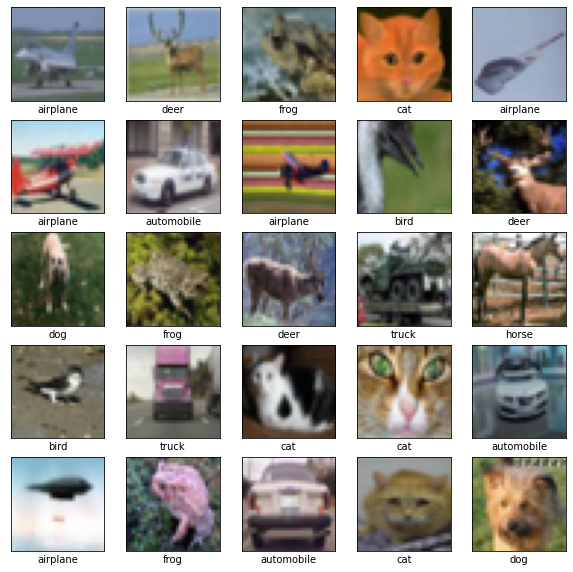

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## 4. Preparar datos
El set de entrenamiento original era de tamaño `train_images.shape=(50000,32,32,3)` y sus etiquetas `train_labels.shape=(50000, 1)`. Pero usamos uno más pequeño de 2000. Aplanamos el set de entrenamiento y también el de pruebas:

In [6]:
train_images_rows = train_images.reshape(train_images.shape[0], 32 * 32 * 3) # train_images_rows.shape 2000 x 3072
test_images_rows = test_images.reshape(test_images.shape[0], 32 * 32 * 3) # test_images_rows.shape 100 x 3072

## 5. Construcción del modelo


El algoritmo k-Means consta de tres pasos:

1. **Inicialización:** se selecciona el número de centroides (grupos, `NUM_CENTROIDS`) y se crean con el tamaño de las imágenes, aleatorios.  
2. **Asignación:** cada imagen es asignada a su centroide más cercano.  
3. **Actualización centroides:** se actualiza la posición del centroide de cada grupo tomando como nuevo centroide la posición del promedio de los objetos pertenecientes a dicho grupo.

Se repiten los pasos 2 y 3 hasta que los centroides están lo suficientemente cerca.

In [33]:
# Paso 1: Inicialización
NUM_IMAGES = train_images.shape[0] # 2000
NUM_CENTROIDS = 10
centroids = np.random.rand(NUM_CENTROIDS, 32*32*3)

# Paso 2: Asignación a centroide más cercano
def assignment(centroids):
  closest = []

  for j in range(NUM_IMAGES):
    distances_from_centroid = []
    for i in range(NUM_CENTROIDS):
      distances_from_centroid.append(np.sum(np.abs(centroids[i, :] - train_images_rows[j,:])))
    #print(distances_from_centroid)
    closest.append(np.argmin(distances_from_centroid))
  #print(closest)
  return closest

# Paso 3: Actualización centroides
def update(closest):
  new_centroids = np.zeros((NUM_CENTROIDS, 32*32*3))
  for c in range(NUM_CENTROIDS):
    num = 0
    # Takes all images assigned to the centroid and calculates average
    for i in range(NUM_IMAGES):
      if (closest[i] == c):
        num = num + 1
        #print(train_images_rows[i, :])
        new_centroids[c, :] += train_images_rows[i, :]
    # Discard if there are no images (num=0) assigned to a centroid
    if (num>0):
      new_centroids[c, :] = new_centroids[c, :] / num
    #print("Centroid ", c ," has ", num, " images assigned.")
  return new_centroids


In [34]:
# Ejecución del algoritmo kMeans: bucle hasta que los centroides no cambian
centroides = np.random.rand(NUM_CENTROIDS, 32*32*3)
while True:
    cercanos = assignment(centroides)
    nuevos_centroides = update(cercanos)
    print("Convergence: ", np.sum(nuevos_centroides)-np.sum(centroides))
    if (np.allclose(nuevos_centroides, centroides)):
      break
    centroides = nuevos_centroides

Convergence:  172.67923829299252
Convergence:  28.72359725674505
Convergence:  -139.23101198028598
Convergence:  -124.10774790947835
Convergence:  -87.92745146562083
Convergence:  -67.62053227716024
Convergence:  -68.65949928424925
Convergence:  -29.6072293528141
Convergence:  -26.871525413580457
Convergence:  -18.79237808531252
Convergence:  -10.17196289709318
Convergence:  -19.977724357795523
Convergence:  -13.071831729415862
Convergence:  -16.109091959653597
Convergence:  -7.619156987513634
Convergence:  1.0584599019693997
Convergence:  8.807581807837778
Convergence:  16.377708256362894
Convergence:  3.8396209794536844
Convergence:  3.469163387106164
Convergence:  4.767351199783661
Convergence:  -2.0572934665324283
Convergence:  -3.175292904687012
Convergence:  -0.7491869600489736
Convergence:  0.0


En el paso 2 anterior (asignación de centroides), se puede usar la distancia L1 ó L2 (cuadrática). Para la diferencia cuadrática, simplemente cambiar la línea  por la siguiente:

`distances_from_centroid.append(np.sqrt(np.sum(np.abs(centroids[i, :] - train_images_rows[j,:]))))`

## 6. Evaluación
Para ver los 10 centroides generados, mostramos las imágenes:

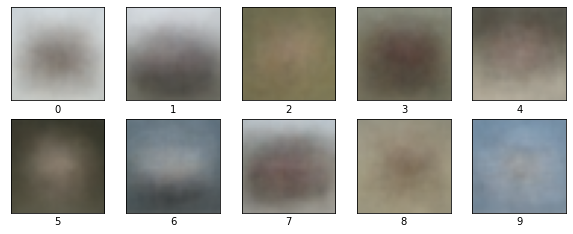

In [35]:
centroides_img = nuevos_centroides.reshape(nuevos_centroides.shape[0], 32, 32, 3)

plt.figure(figsize=(10,10))
for i in range(NUM_CENTROIDS):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(centroides_img[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(i)

plt.show()